In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets

In [71]:
'''
Since the data is small (~180MB) it is faster to load to RAM
Class is in memory wrapper of the CIFAR10 dataset
'''
class CIFAR10(Dataset):
    def __init__(self, root='./data', train=True, download=True, transform=None):
        super().__init__()

        dataset = datasets.CIFAR10(root=root, train=train, download=download)

        self.imgs = torch \
            .from_numpy(dataset.data) \
            .permute(0, 3, 1, 2) \
            .float() / 255.
        
        self.labels = torch.tensor(dataset.targets, dtype=torch.long)
        self.transform = transform
        self.classes = dataset.classes
    
    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, index):
        x = self.imgs[index]
        y = self.labels[index]

        if self.transform is not None:
            x = self.transform(x)

        return x, y

In [72]:
from torch.utils.data import DataLoader

In [73]:
train_data = CIFAR10(root="./data", train=True,  transform=None, download=True)
test_data  = CIFAR10(root="./data", train=False, transform=None, download=True)

train_ld = DataLoader(train_data, batch_size=128, shuffle=True)
test_ld  = DataLoader(test_data,  batch_size=256, shuffle=False)

In [74]:
import matplotlib.pyplot as plt

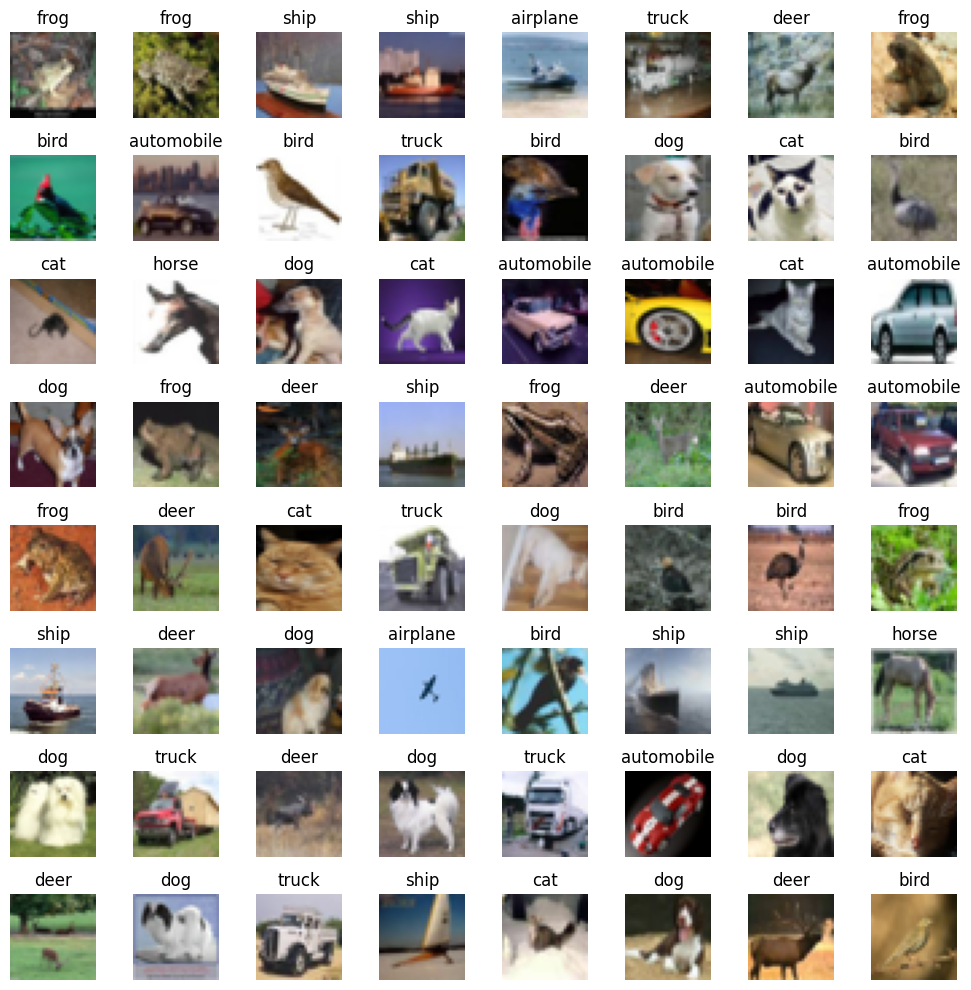

In [6]:
def visualize(loader, classes, n=64):
    # get images and labels
    imgs, labels = next(iter(loader))
    n = min(imgs.shape[0], n)
    
    imgs = imgs[:n]
    labels = labels[:n]

    # compute rows/cols
    cols = int(n**0.5)
    rows = (n + cols - 1) // cols

    # plot
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(imgs[i].permute(1, 2, 0))
        plt.title(classes[labels[i]])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize(train_ld, train_data.classes)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
import torch.nn as nn

In [9]:
class CNN(nn.Module):
    def __init__(self, num_layers=1, out_channels=1):
        super().__init__()

        layers = []
        in_channels = 3

        for _ in range(num_layers):
            layers.append(nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                bias=False
            ))
            layers.append(nn.LeakyReLU(inplace=True))

            in_channels = out_channels

        self.layers = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(out_channels, 10)

    def forward(self, x):
        x = self.layers(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        return x

In [10]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        out = model(x)
        loss = loss_fn(out, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.shape[0]

        y_hat = out.argmax(1)

        correct += (y_hat == y).sum().item()
        total += y.shape[0]

    return {
        "loss" : running_loss / total,
        "acc" : correct / total
    }


In [11]:
@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        loss = loss_fn(out, y)

        running_loss += loss.item() * x.size(0)
        y_hat = out.argmax(1)
        correct += (y_hat == y).sum().item()
        total += y.shape[0]

    return {
        "loss" : running_loss / total,
        "acc" : correct / total
    }


In [12]:
from torch.optim import AdamW
import pandas as pd

In [ ]:
def run_model_tests(
    mode, train_ld, test_ld,
    num_iter=10, num_epochs=20, num_samples=1,
    lr=1e-4, decay=1e-4, device='cpu'
):
    
    results = []
    for val in [2**i for i in range(num_iter)]:
        for s in range(num_samples):
            match mode:
                case 'channels':
                    model = CNN(out_channels=val).to(device)
                case 'layers':
                    model = CNN(num_layers=val).to(device)
                case _:
                    raise "Error: invalid mode"
            
            loss_fn = nn.CrossEntropyLoss().to(device)
            optimizer = AdamW(model.parameters(), lr=lr, weight_decay=decay)

            for epoch in range(num_epochs):
                train_res = train_one_epoch(model, train_ld, optimizer, loss_fn, device)
                test_res = evaluate(model, test_ld, loss_fn, device)

                results.append({
                    "val": val,
                    "sample": s+1,
                    "epoch": epoch+1,
                    "train_loss": train_res["loss"],
                    "train_acc": train_res["acc"],
                    "test_loss": test_res["loss"],
                    "test_acc": test_res["acc"]
                })

            print(
                f"{val:03d}-{mode} | "
                f"sample {s+1:03d}/{num_samples} | "
                f"epoch {epoch+1:03d}/{num_epochs} | "
                f"training loss={train_res["loss"]:.4f}, acc={train_res["acc"]:.4f} | "
                f"test loss={test_res["loss"]:.4f}, acc={test_res["acc"]:.4f}"
            )

    return pd.DataFrame(results)


In [ ]:
layers_df = run_model_tests('layers', train_ld, test_ld, num_iter=8, num_samples=15, num_epochs=25, device=device)
channels_df = run_model_tests('channels', train_ld, test_ld, num_iter=8, num_samples=15, num_epochs=25, device=device)

In [24]:
print("Channels\n",channels_df.head())
print("\nLayers\n", layers_df.head())

Channels
    val  sample  epoch  train_loss  train_acc  test_loss  test_acc
0    1       1      1    2.446552        0.1   2.441667       0.1
1    1       1      2    2.438784        0.1   2.434738       0.1
2    1       1      3    2.432555        0.1   2.429263       0.1
3    1       1      4    2.427580        0.1   2.424878       0.1
4    1       1      5    2.423571        0.1   2.421333       0.1

Layers
    val  sample  epoch  train_loss  train_acc  test_loss  test_acc
0    1       1      1    2.546670        0.1   2.544949       0.1
1    1       1      2    2.543346        0.1   2.541720       0.1
2    1       1      3    2.540186        0.1   2.538624       0.1
3    1       1      4    2.537137        0.1   2.535590       0.1
4    1       1      5    2.534150        0.1   2.532657       0.1


In [ ]:
layers_df.to_csv('./experiment/layers.csv')
channels_df.to_csv('./experiment/channels.csv')

In [ ]:
def plot_metrics(df):
    metrics = ["train_loss", "train_acc", "test_loss", "test_acc"]

    df = df.copy(deep=True)
    df = df.groupby(["val", "epoch"])[metrics].mean().reset_index()

    _, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    axes = axes.flatten()

    for ax, metric in zip(axes, metrics):
        for v in df["val"].unique():
            val_df = df[df["val"] == v]
            ax.plot(val_df["epoch"], val_df[metric], label=v)

        ax.set_title(metric)
        ax.set_xlabel("epoch")
        ax.set_ylabel(metric)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

Channels


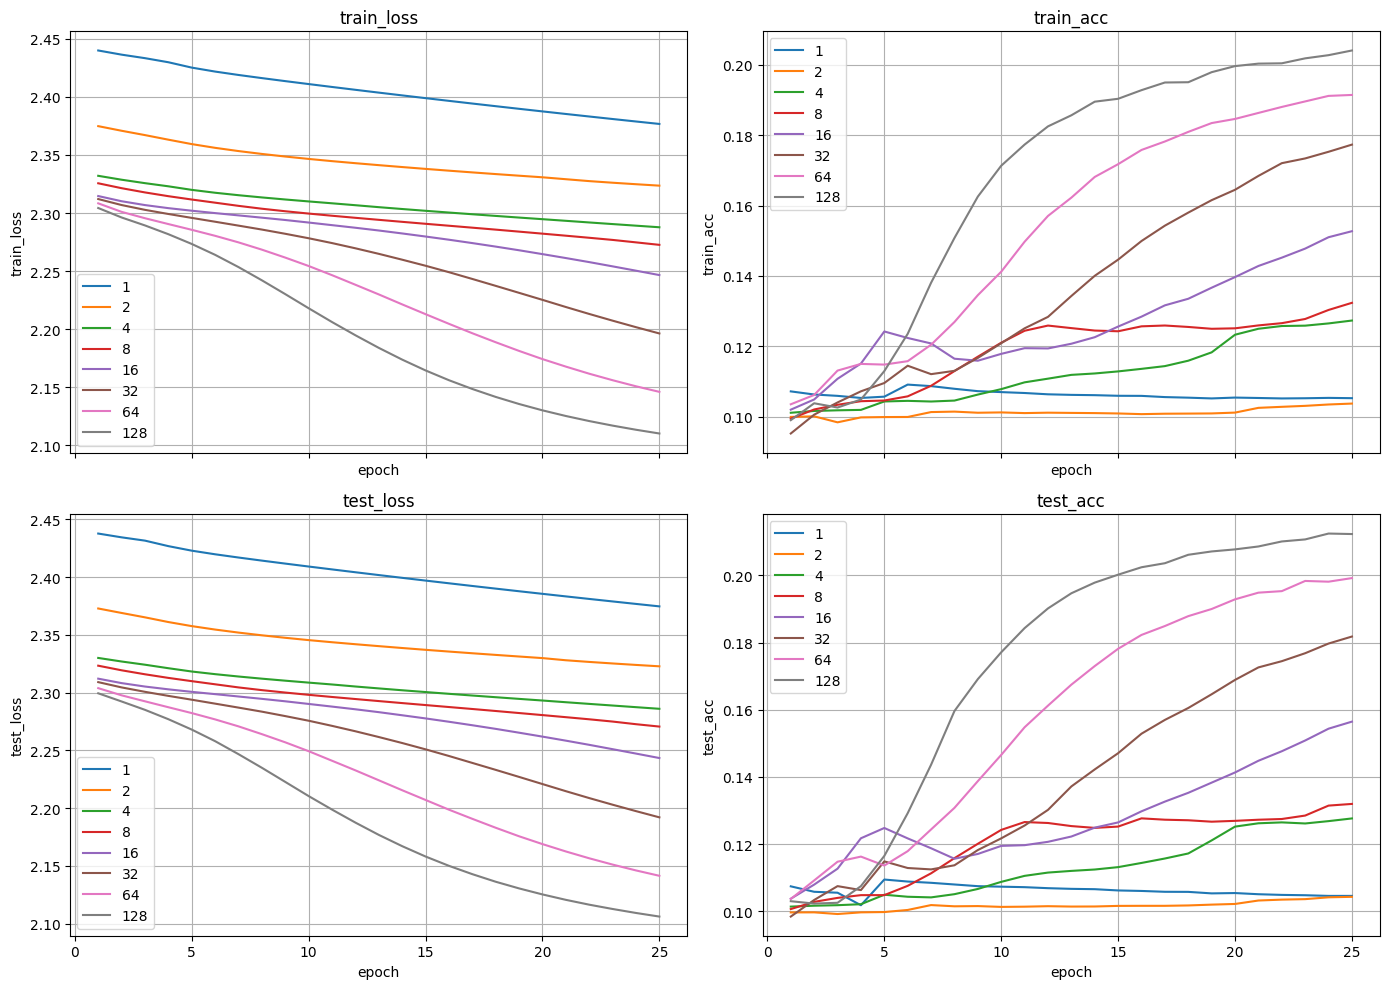

Layers


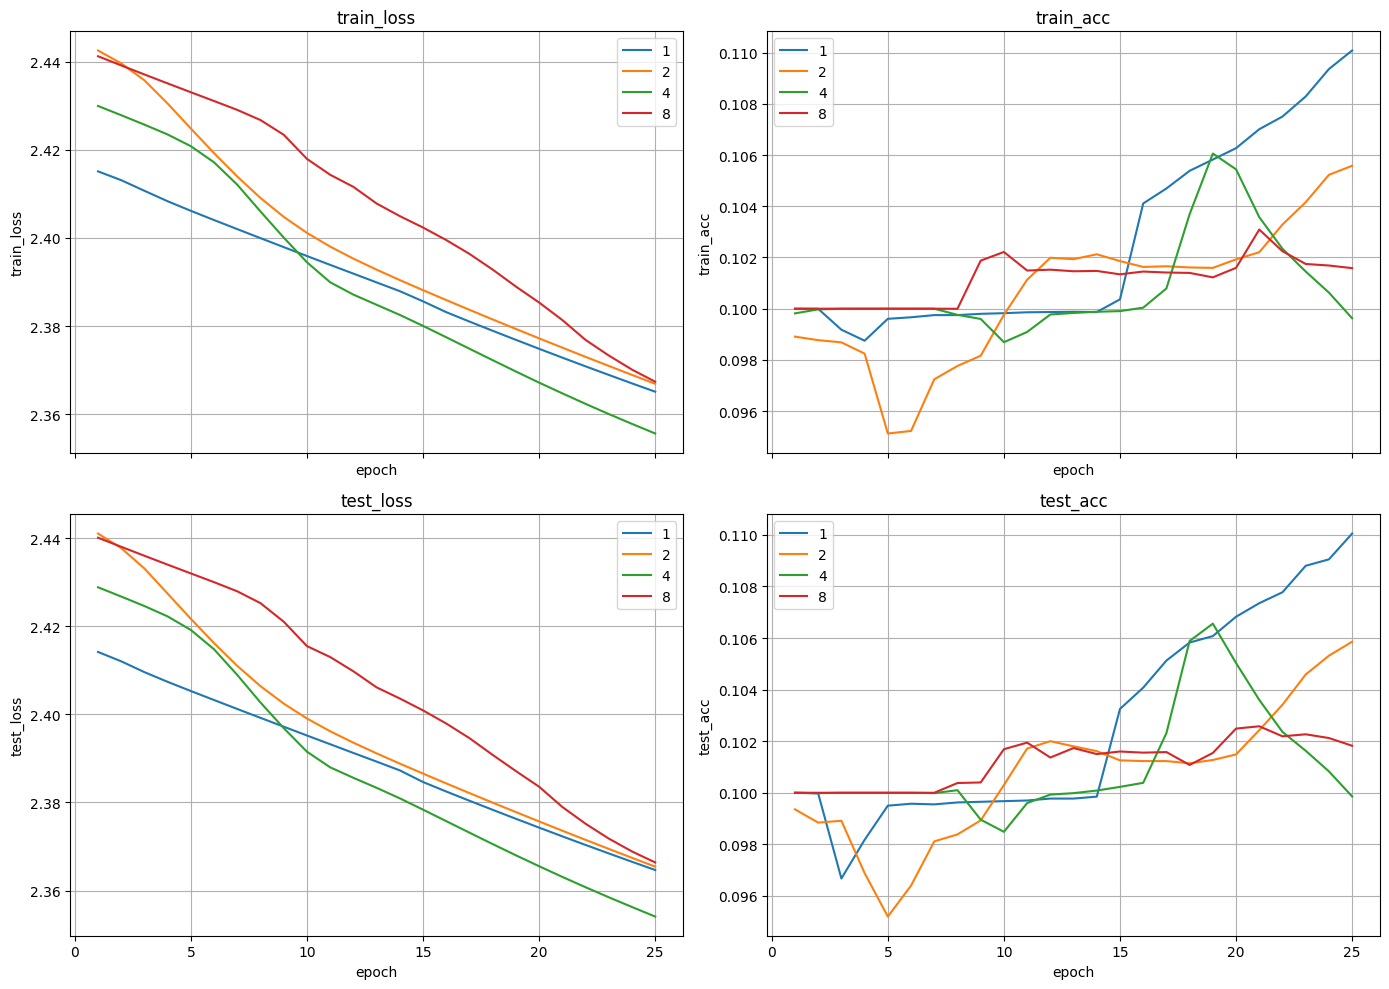

In [77]:
def filter_failed(df):
    df = df.copy(deep=True)
    
    failed_train = df[(df["epoch"] > 20) & (df["test_acc"] == 0.10)]
    failed_train = failed_train.groupby(["val", "sample"])["test_acc"].count()
    failed_train = failed_train[failed_train > 3]
    failed_train = failed_train.to_frame().reset_index(inplace=False)[["val", "sample"]]

    merged = pd.merge(df, failed_train, on=['val', 'sample'], how='left', indicator=True)
    merged = merged[merged["_merge"] == 'left_only']
    merged = merged.drop(columns=["_merge"])

    return merged

print("Channels")
plot_metrics(filter_failed(channels_df))
print("Layers")
plot_metrics(filter_failed(layers_df))